In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from statsmodels.tsa.api import Holt

import math

import summarize
import model

In [2]:
df = pd.read_csv('fitbit/tidy.csv')

In [3]:
# We decided to remove the food logs because they were mostly 0

In [4]:
df.head(5)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [5]:
summarize.df_summary(df)

--- Shape: (225, 10)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB
--- Descriptions
           date calories_burned steps    distance      floors  \
count       225             225   225  225.000000  225.000000   
unique      225             207   213         NaN         NaN   
top     9/12/18           2,145     0         NaN         NaN   
freq          1               4    12         NaN         NaN   
mea

In [6]:
# change date to datetime
# remove commas to change to numeric dtypes

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df = df.set_index(df['date'])

In [9]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,,
2018-04-26,2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566
2018-04-27,2018-04-27,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2018-04-28,2018-04-28,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
2018-04-29,2018-04-29,"2,851","1,639",0.77,0,891,122,0,0,602
2018-04-30,2018-04-30,"2,825","1,323",0.62,0,880,104,0,0,540


In [10]:
df['calories_burned'] = df['calories_burned'].str.replace(',','')
df['steps'] = df['steps'].str.replace(',','')
df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
df['activity_calories'] = df['activity_calories'].str.replace(',','')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 10 columns):
date                      225 non-null datetime64[ns]
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 19.3+ KB


In [12]:
df.dtypes

date                      datetime64[ns]
calories_burned                   object
steps                             object
distance                         float64
floors                             int64
minutes_sedentary                 object
minutes_lightly_active             int64
minutes_fairly_active              int64
minutes_very_active                int64
activity_calories                 object
dtype: object

In [13]:
# change the data types to numeric dtypes
df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)

In [14]:
df.dtypes

date                      datetime64[ns]
calories_burned                    int64
steps                              int64
distance                         float64
floors                             int64
minutes_sedentary                  int64
minutes_lightly_active             int64
minutes_fairly_active              int64
minutes_very_active                int64
activity_calories                  int64
dtype: object

In [15]:
# Add nnew column to track total minutes accounted for. There are 1440 minutes in a day
# Use this column to track how long they were wearing the fitbit
df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']

In [16]:
df.head(3)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged
date,,,,,,,,,,,
2018-04-26,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440
2018-04-27,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440
2018-04-28,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890


In [17]:
# distance per step - the average person takes a stride of about 2.1 to 2.5 feet 
# (woman's average 2.2) (average man)
# (our person takes a stride of 2.4816, probably a make)
df['distance per step'] = (df['distance'] / df['steps']) 

In [18]:
# dont know if miles or km
# mile = 2.5 step stride
# km = 1.5 step stride

# if we assume that steps are in miles, we can assume the participant is an American, therefore cn take American holidays into consideration
# taking calorie intake and stride into account, can find approximate weight for either male or female


In [19]:
df.head(20)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance per step
date,,,,,,,,,,,,
2018-04-26,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471
2018-04-29,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470
2018-04-30,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469
2018-05-01,2018-05-01,3292,2581,1.22,0,919,167,13,2,1068,1101,0.000473
2018-05-02,2018-05-02,2660,1372,0.65,0,927,90,0,0,419,1017,0.000474
2018-05-03,2018-05-03,3121,2232,1.05,0,876,157,16,0,1006,1049,0.000470
2018-05-04,2018-05-04,2522,904,0.43,1,1012,61,0,0,269,1073,0.000476


In [20]:
# finish this
def prepare_data(df):
    df = pd.read_csv('fitbit/tidy.csv')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index(df['date'])
    df['calories_burned'] = df['calories_burned'].str.replace(',','')
    df['steps'] = df['steps'].str.replace(',','')
    df['minutes_sedentary'] = df['minutes_sedentary'].str.replace(',','')
    df['activity_calories'] = df['activity_calories'].str.replace(',','')
    df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps', 'minutes_sedentary', 'activity_calories']].apply(pd.to_numeric)
    df['total_minutes_logged'] = df['minutes_sedentary'] + df['minutes_lightly_active'] + df['minutes_fairly_active'] + df['minutes_very_active']
    df['distance per step'] = df['distance'] / df['steps']
    return df

In [21]:
# day of the week vs floor count - is there a spike difference?

In [22]:
df.head(1)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance per step
date,,,,,,,,,,,,
2018-04-26,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471


In [23]:
# look at the steps average in days, weeks, and months

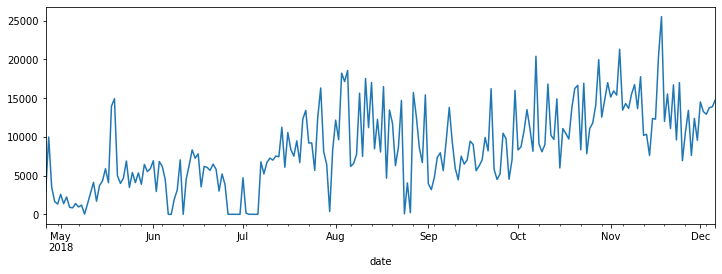

In [24]:
df['steps'].resample("D").mean().plot(figsize=(12,4))

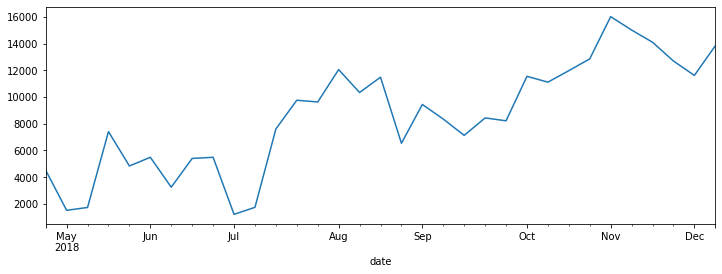

In [25]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

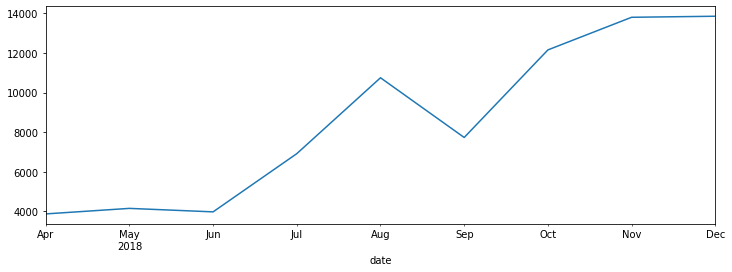

In [26]:
df['steps'].resample("M").mean().plot(figsize=(12,4))

In [27]:
df.steps.sort_values().head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64

In [28]:
df.total_minutes_logged.sort_values().head(15)

date
2018-08-26     41
2018-08-18    749
2018-11-02    816
2018-06-03    817
2018-08-11    822
2018-11-07    824
2018-05-28    832
2018-11-19    834
2018-09-16    838
2018-11-26    849
2018-12-01    849
2018-11-13    850
2018-11-24    862
2018-05-22    869
2018-07-12    870
Name: total_minutes_logged, dtype: int64

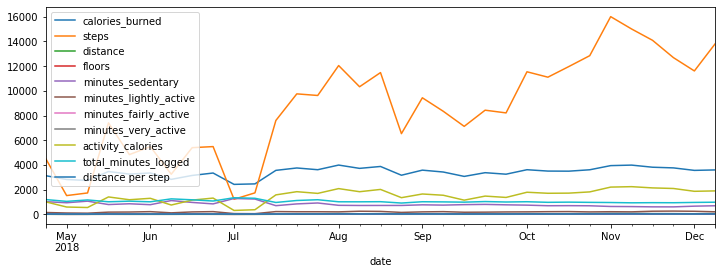

In [29]:
fig = df.resample('W').mean().plot(figsize= (12,4))

In [30]:
weekday_totals = df.groupby(df.index.weekday).sum()

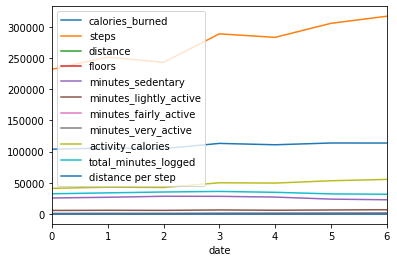

In [31]:
weekday_totals.plot()

How does activity change over time?

In [32]:
df.dtypes

date                      datetime64[ns]
calories_burned                    int64
steps                              int64
distance                         float64
floors                             int64
minutes_sedentary                  int64
minutes_lightly_active             int64
minutes_fairly_active              int64
minutes_very_active                int64
activity_calories                  int64
total_minutes_logged               int64
distance per step                float64
dtype: object

In [33]:
df = df.resample('D').mean()

Text(0.5, 1.0, 'Average Sedentary Minutes by Day')

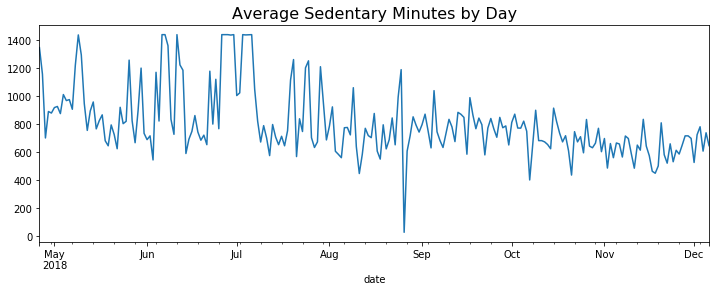

In [34]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Lighltly Active Minutes by Day')

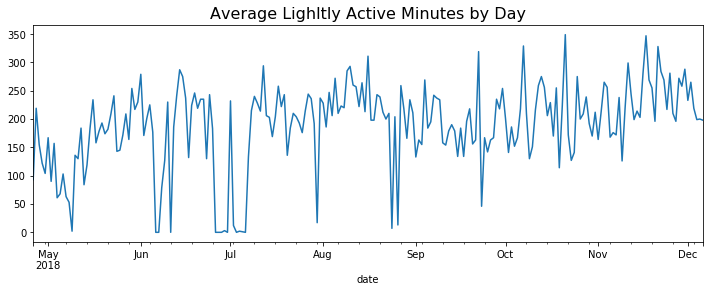

In [35]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lighltly Active Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Day')

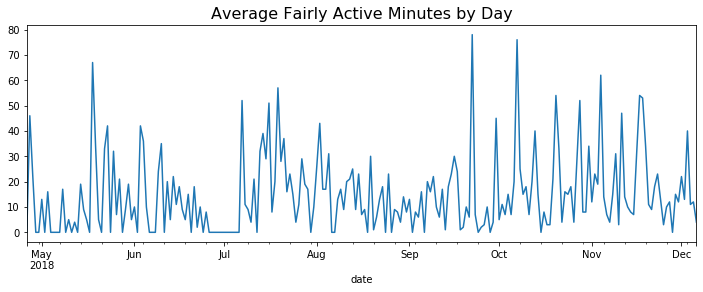

In [36]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Day')

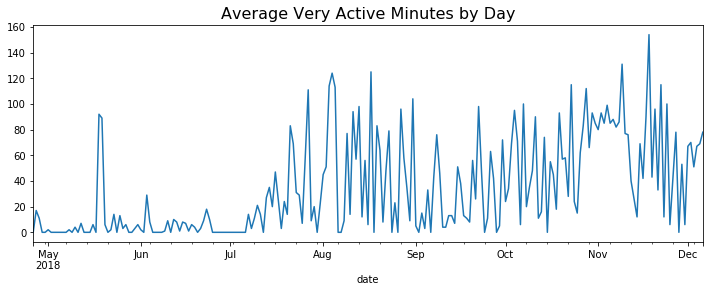

In [37]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Day', fontsize=16)

# Takeaway: Thanksgiving was on Thurs Nov 22nd and it was user's 7th most active day and 5th most very active day

Text(0.5, 1.0, 'Average Minutes per Activity Level by Day')

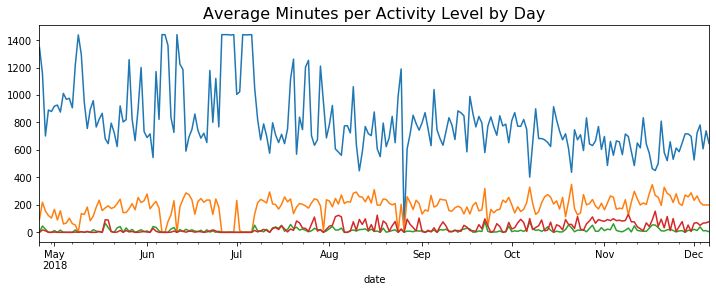

In [38]:
df = df.resample('D').mean()

fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Day', fontsize=16)

# Takeaways: 
    - August 26th, user only wore fitbit for 41 mins
    - Wore fitbit all day a few times in July but never again after that

In [39]:
df = df.resample('W').mean()

Text(0.5, 1.0, 'Average Sedentary Minutes by Week')

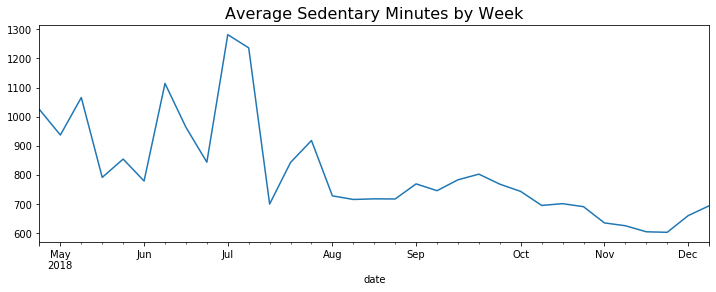

In [40]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Lighltly Active Minutes by Week')

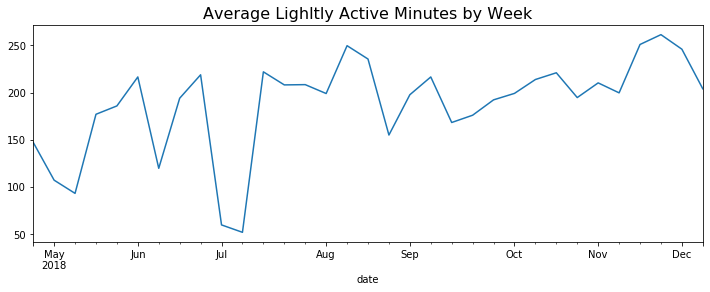

In [41]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lighltly Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Week')

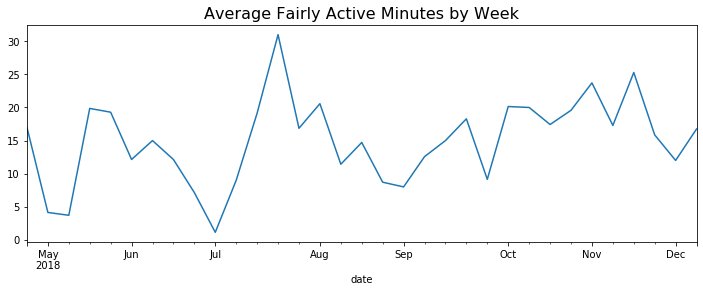

In [42]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Week')

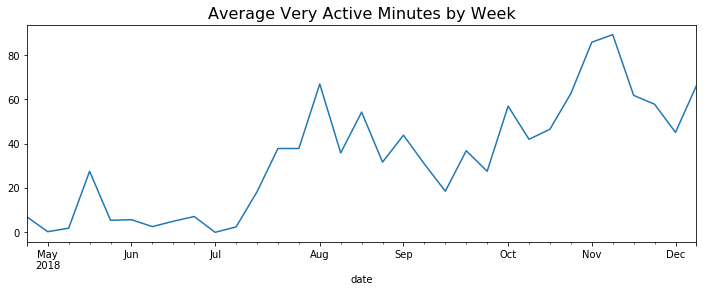

In [43]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Minutes per Activity Level by Week')

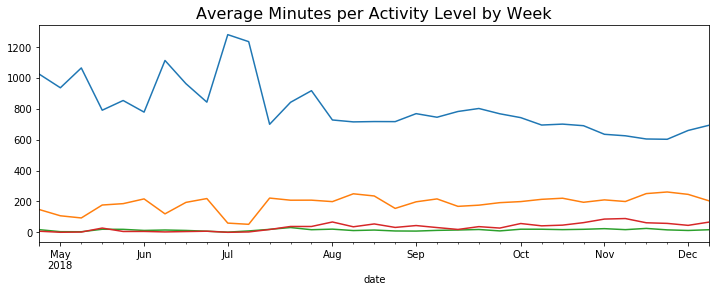

In [44]:
df = df.resample('W').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Week', fontsize=16)

# Takeaway: April - July active levels have high variance including a very inactive first week of July. August through Dec is more constant. 

In [45]:
df = df.resample('M').mean()

Text(0.5, 1.0, 'Average Sedentary Minutes by Month')

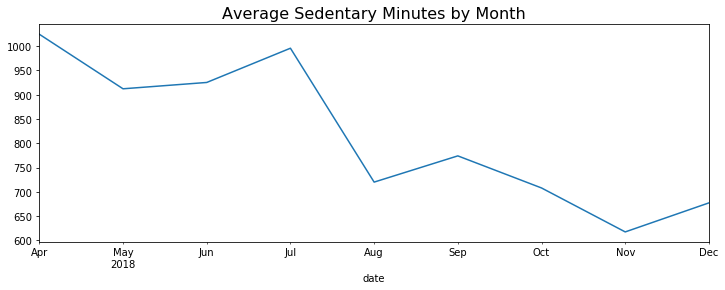

In [46]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Lightly Active Minutes by Month')

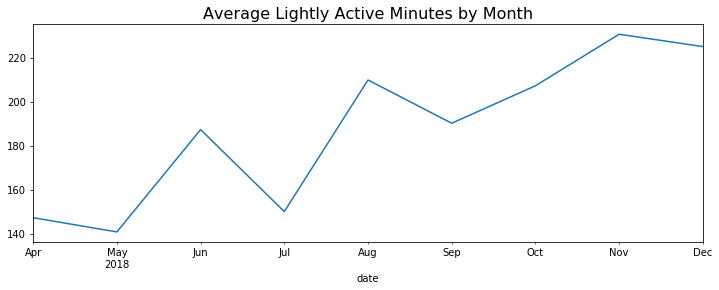

In [47]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lightly Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Month')

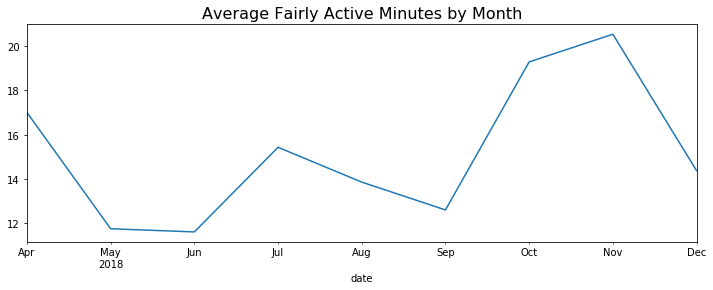

In [48]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Month')

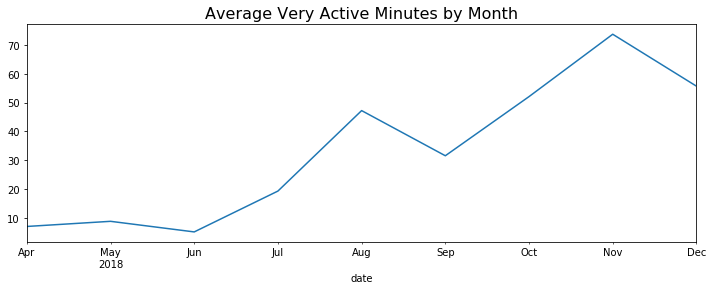

In [49]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Minutes per Activity Level by Month')

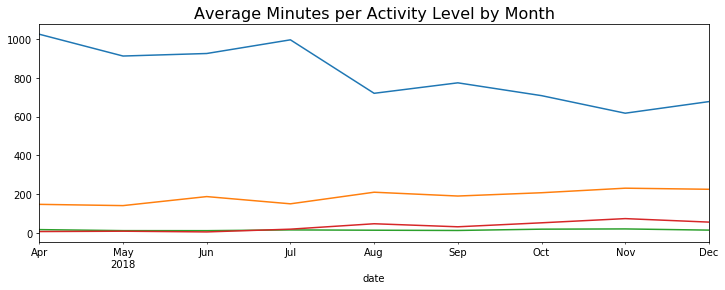

In [50]:
df = df.resample('M').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Month', fontsize=16)

# Takeaway: Sedentary levels go down over time. Fitbit user becomes more consistently active as time goes on. 

Text(0.5, 1.0, 'Average Very Active Minutes by Day of Week')

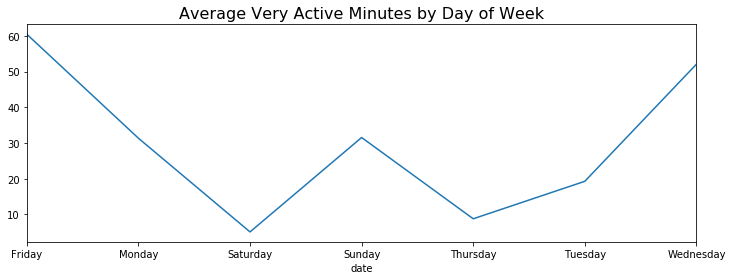

In [51]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_1 = daily_averages['minutes_very_active'].plot(figsize= (12,4))
fig_1.set_title('Average Very Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Day of Week')

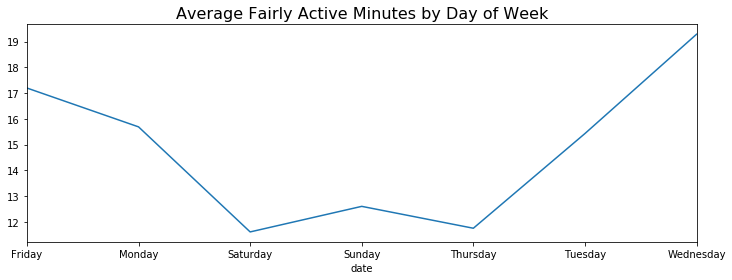

In [52]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_2 = daily_averages['minutes_fairly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Fairly Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Lightly Active Minutes by Day of Week')

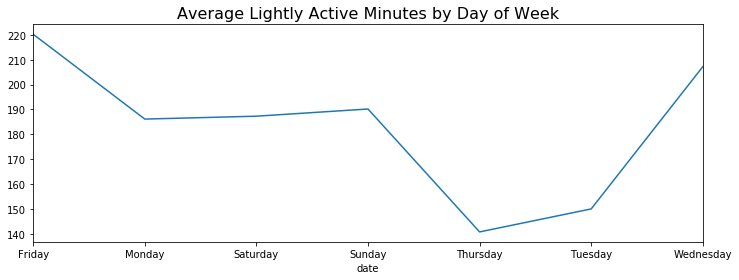

In [53]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_3 = daily_averages['minutes_lightly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Lightly Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Sedentary Minutes by Day of Week')

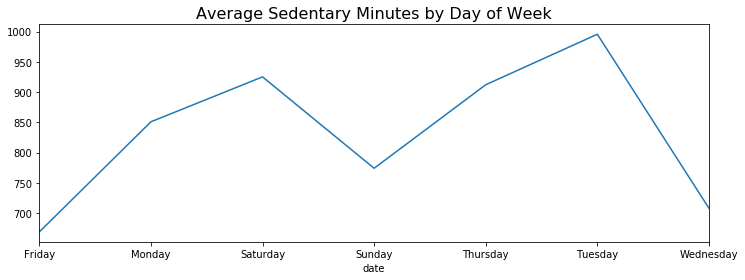

In [54]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_4 = daily_averages['minutes_sedentary'].plot(figsize= (12,4))
fig_4.set_title('Average Sedentary Minutes by Day of Week', fontsize=16)

# Takeaway: Fitbit user is most active on Fridays and Wednesday. They do next to nothing on Tuesday and are also very inactive on Saturdays

Modeling

In [55]:
df.reset_index().head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance per step
0,2018-04-30,3128.5,4515.5,2.1275,5.75,1024.5,147.25,17.0,7.0,1011.0,1195.75,0.000471
1,2018-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df = pd.read_csv('fitbit/tidy.csv')

In [57]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [58]:
df = prepare_data(df)

In [59]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance per step
date,,,,,,,,,,,,
2018-04-26,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471
2018-04-29,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470
2018-04-30,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469


In [60]:
#split data
train_size = int(len(df.index)*.70)
train, test = df[:train_size], df[(train_size):]

In [61]:
train.shape

(157, 12)

In [62]:
test.shape

(68, 12)

In [63]:
predictions = pd.DataFrame(test.steps)

In [64]:
predictions['simple_average'] = train.steps.mean()

In [65]:
predictions.head(3)

,steps,simple_average
date,,
2018-09-30,15991,6567.464968
2018-10-01,8307,6567.464968
2018-10-02,8702,6567.464968


In [66]:
mse = metrics.mean_squared_error(predictions['steps'], predictions['simple_average'])
rmse = math.sqrt(mse)
print('MSE:  {}'.format(mse))
print('RMSE: {}'.format(rmse))

MSE:  57072047.88966859
RMSE: 7554.604416491216


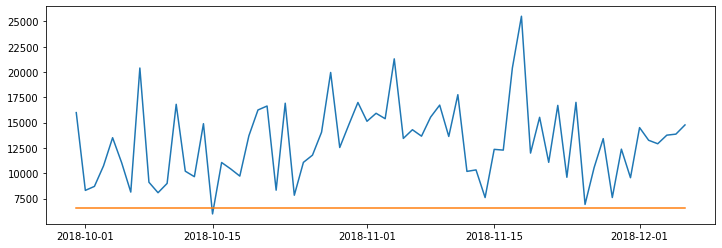

In [67]:
plt.figure(figsize=(12, 4))
plt.plot(predictions.steps)
plt.plot(predictions.simple_average)

In [68]:
df = pd.read_csv('fitbit/tidy.csv')

In [69]:
df = prepare_data(df)

In [70]:
df.dtypes

date                      datetime64[ns]
calories_burned                    int64
steps                              int64
distance                         float64
floors                             int64
minutes_sedentary                  int64
minutes_lightly_active             int64
minutes_fairly_active              int64
minutes_very_active                int64
activity_calories                  int64
total_minutes_logged               int64
distance per step                float64
dtype: object

In [71]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [72]:
train, test = split_store_data(df, train_prop=.70)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 157
Testing Observations: 68


In [73]:
train = train.set_index('date')
test = test.set_index('date')

In [74]:
target_vars=['steps']
df = df.resample('D')[target_vars].sum()

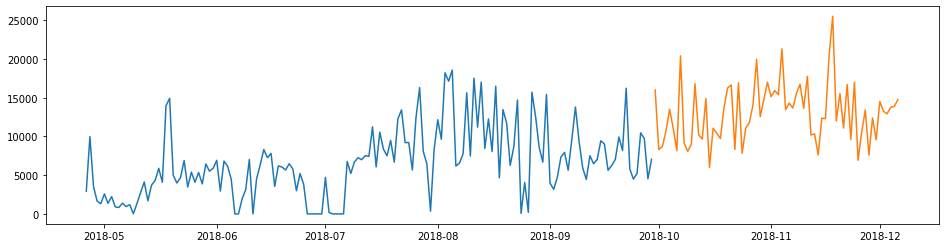

In [75]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

In [76]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [77]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [78]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [79]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [80]:
yhat = pd.DataFrame(test[target_vars])

In [81]:
yhat.head(3)

,steps
date,
2018-09-30,15991
2018-10-01,8307
2018-10-02,8702


Last Observed

In [82]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [83]:
yhat.head(3)

,steps
date,
2018-09-30,7043
2018-10-01,7043
2018-10-02,7043


steps -- MSE: 51102765.85 RMSE: 7148.62


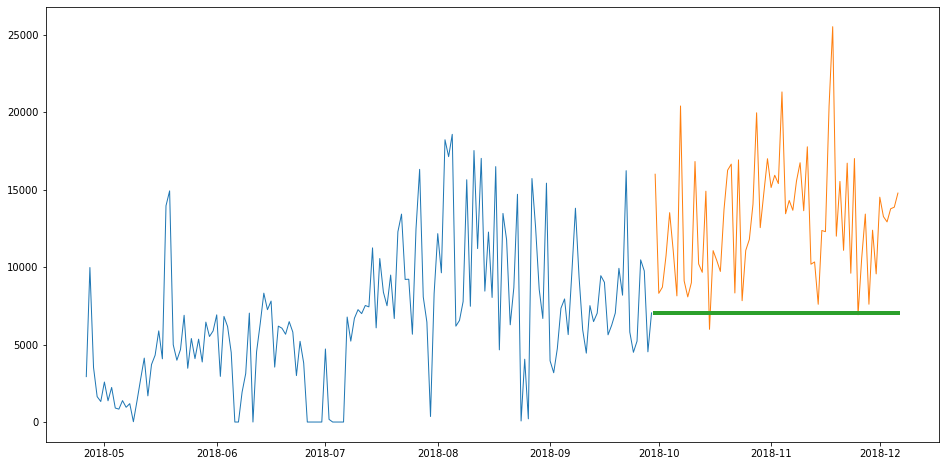

In [84]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

Simple Average

In [85]:
for var in target_vars:
    yhat[var] = train[var].mean()

steps -- MSE: 57072047.89 RMSE: 7554.60


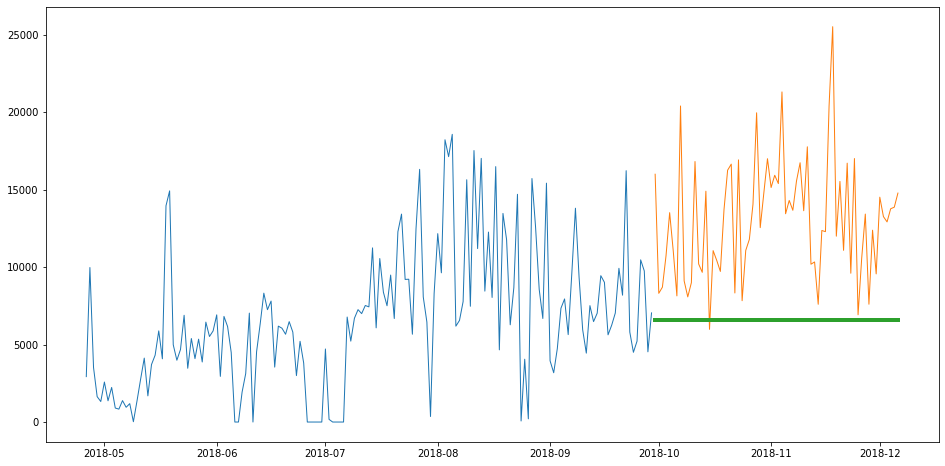

In [86]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

Moving Average

In [87]:
periods = 14
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

steps -- MSE: 42258628.82 RMSE: 6500.66


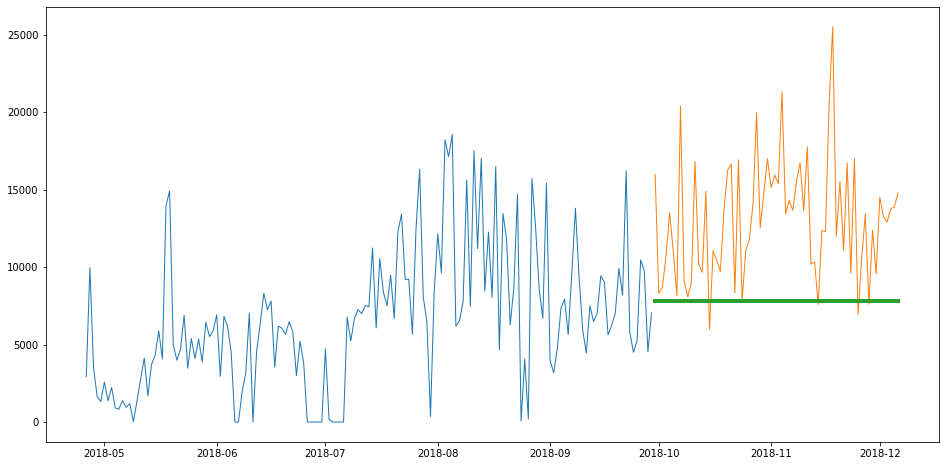

In [88]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

Holt's Linear Trend

steps -- MSE: 85852024.23 RMSE: 9265.64


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


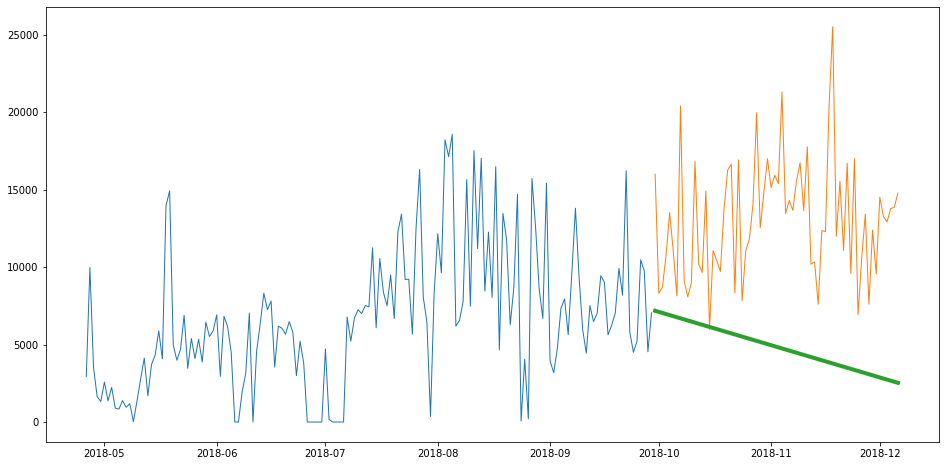

In [89]:
for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)

# Prophet Model

In [90]:
"""import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")
from acquire import get_store_data
from prepare import prep_store_data_prophet, split_store_data
from summarize import df_summary"""

'import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom fbprophet import Prophet\n%matplotlib inline\npd.plotting.register_matplotlib_converters()\nimport warnings\nwarnings.filterwarnings("ignore")\nfrom acquire import get_store_data\nfrom prepare import prep_store_data_prophet, split_store_data\nfrom summarize import df_summary'